<a href="https://colab.research.google.com/github/Donghyuk-Jang/ML/blob/main/4.%EC%9D%98%EC%82%AC%EA%B2%B0%EC%A0%95%ED%8A%B8%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# 데이터 로딩 및 확인 
iris_data = load_iris()
print(iris_data['data'][:3])
print(iris_data['target'][:3])

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]]
[0 0 0]


In [ ]:
# 의사결정나무 모델 생성
dt_clf_gini = DecisionTreeClassifier(random_state=2022,criterion='gini')
dt_clf_entropy = DecisionTreeClassifier(random_state=2022,criterion='entropy')

In [ ]:
# 학습, 테스트 데이터 분리
X_train,X_test,y_train,y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2, random_state=2022)

In [ ]:
# 의사결정나무 학습 
dt_clf_gini.fit(X_train,y_train)
dt_clf_entropy.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', random_state=2022)

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(dt_clf_gini, out_file='tree.dot', class_names=iris_data.target_names, feature_names=iris_data.feature_names, impurity=True, filled=True)

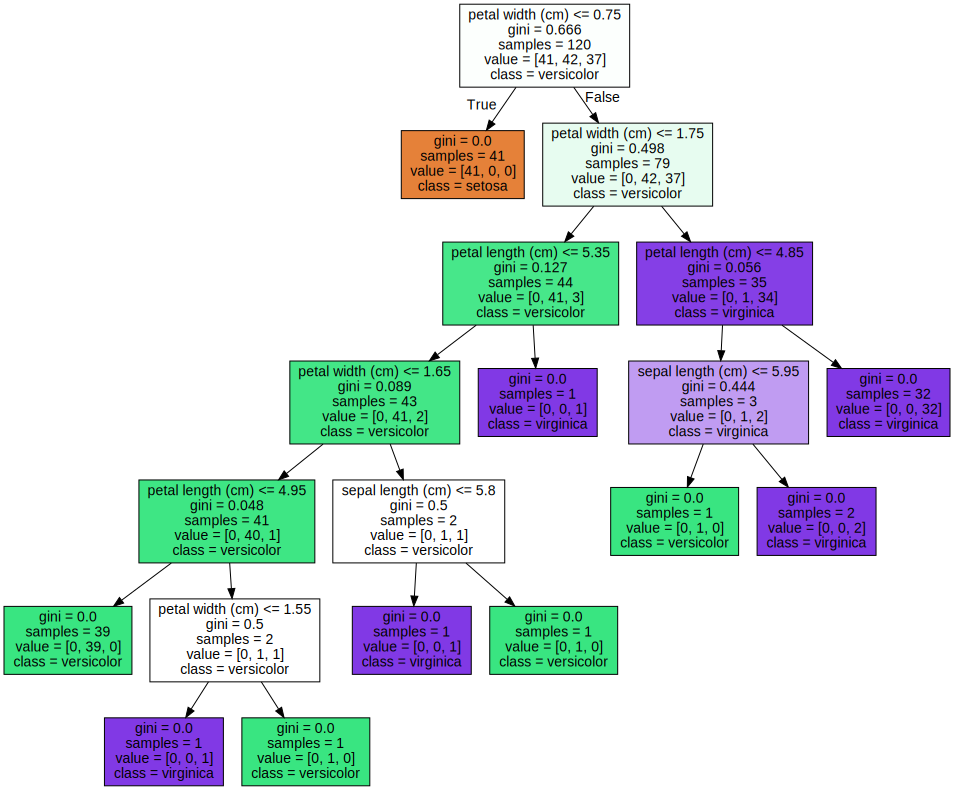

In [ ]:
import graphviz
with open('tree.dot') as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
# 사전 가지치기
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix


params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

# max_depth : 노드를 분할하기 위한 최소한의 샘플 데이터 수로 과적합 제어 용도로 사용
# min_samples_split : leaf가 되기 위한 최소한의 샘플 데이터 수로 과적합 제어 용도로 사용
# min_samples_leaf : 트리의 최대 깊이를 규정 

gcv = GridSearchCV(estimator=dt_clf_entropy,param_grid=params)
gcv.fit(X_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(criterion='entropy',
                                              random_state=2022),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [ ]:
model = gcv.best_estimator_
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print(f'Train score {accuracy_score(y_train_pred,y_train)}')
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

Train score 0.9666666666666667
Test score 0.9333333333333333


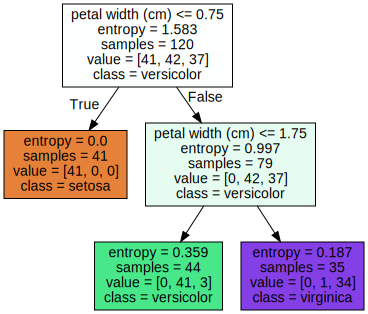

<Figure size 1440x1440 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,20))
export_graphviz(model, out_file='tree.dot', class_names=iris_data.target_names, feature_names=iris_data.feature_names, impurity=True, filled=True)
with open('tree.dot') as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
# 사후 가지치기
#DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process.
# R(T)만 줄이려고 한다면 트리의 규모가 커져 (가지 수가 많아짐) 오버피팅이 될 수 있다. 
# a는 남길 리프 노드 개수를 정하기 때문에 a를 조절하면서 오버피팅을 방지할 수 있다. 
# a값이 커질수록 가지치기하는 노드가 많아진다.
path = dt_clf_entropy.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

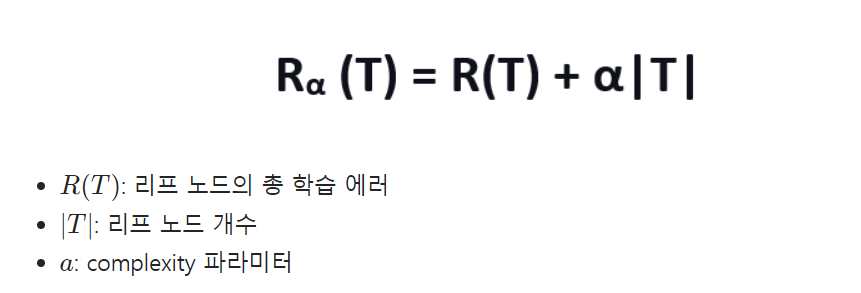

In [ ]:
from sklearn import tree

clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=2022, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

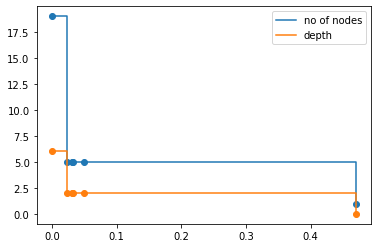

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

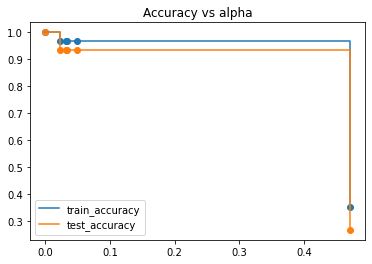

In [ ]:
train_acc = []
test_acc = []
for c in clfs:
    y_train_pred = c.predict(X_train)
    y_test_pred = c.predict(X_test)
    train_acc.append(accuracy_score(y_train_pred,y_train))
    test_acc.append(accuracy_score(y_test_pred,y_test))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [ ]:
clf_ = tree.DecisionTreeClassifier(random_state=2022,ccp_alpha=0.1)
clf_.fit(X_train,y_train)
y_train_pred = clf_.predict(X_train)
y_test_pred = clf_.predict(X_test)

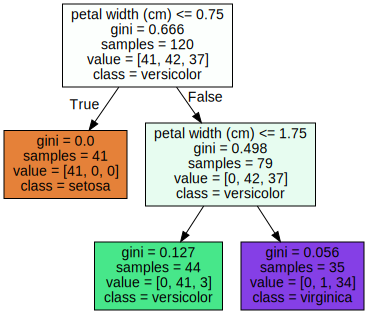

<Figure size 1440x1440 with 0 Axes>

In [ ]:
plt.figure(figsize=(20,20))
export_graphviz(clf_, out_file='tree.dot', class_names=iris_data.target_names, feature_names=iris_data.feature_names, impurity=True, filled=True)
with open('tree.dot') as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

In [ ]:
# https://www.kaggle.com/arunmohan003/pruning-decision-trees-tutorial (참조)
# https://velog.io/@emseoyk/%ED%95%B8%EC%A6%88%EC%98%A8-ML-with-Kaggle-6.-Decision-Tree-Pruning (참조)